In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import allantools as at

# Measuring the bias and scaling factor of MEMS using Atom interferometer

The idea is to manually increase the temperature of the MEMS with heating tapes and look for offset phase drift in the interferometer phase.

Data acquisition:  
- MEMS data:
    - Temperature: Thermal Couple (TC) collected @ 2Hz using Labjack
    - Acceleration signal: using DAQCard
    - Temperature pin (TPin): using DAQCard
- interferomter signal:
    - Photodiode signal via DAQCard

Interferometer is operated at $2T=20$ with a cycling rate also of around 2Hz.

## Data import

First of all, let us look at the data.

### Temperature data import

In [2]:
TCdata = pd.read_table("20200818/TT20ms_180802020_1100_0.dat", names=["1","2","TC","3"])["TC"]

Text(0, 0.5, 'Temperature [a.u.]')

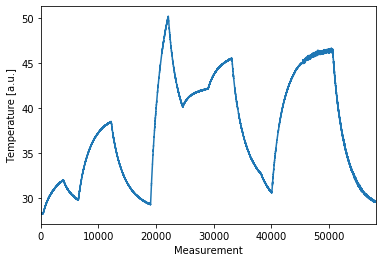

In [7]:
TCdata.plot()
plt.xlabel("Measurement")
plt.ylabel("Temperature [a.u.]")

Temperature data looks perfectly fine. However, around 45000th measurement, the noise in the signal suddenly increased.
- does the noisy part mess up the extraction process? 
    - if we not, we can ignore this concern!

### MEMS data import

The raw mems data are collected for every shot. Each shot contains mems data sampled at 250kHz from the start of the trigger pulse, few ms before the interferomtry, until the end of the interferometry. 

In [8]:
memsdata0=pd.read_table("20200818/1100_mems.txt").T

<code>memsdata0</code> is the raw data of MEMS at 250kHz.
- Columns = measurement
- Rows = 250kHz data

In [10]:
memsdata0.head()

,0,1,2,3,4,5,6,7,8,9,...,49924,49925,49926,49927,49928,49929,49930,49931,49932,49933
0.000000,-8.348576,-8.348905,-8.346602,-8.345944,-8.347589,-8.350221,-8.344957,-8.349563,-8.349234,-8.345944,...,-8.345944,-8.350221,-8.348576,-8.346273,-8.353511,-8.348247,-8.357458,-8.351208,-8.353511,-8.352195
0.000004,-8.347918,-8.347918,-8.346273,-8.345615,-8.347260,-8.349563,-8.344299,-8.348247,-8.348576,-8.345944,...,-8.345286,-8.350221,-8.349892,-8.346602,-8.352524,-8.349892,-8.345944,-8.351208,-8.353511,-8.350550
0.000008,-8.347589,-8.347260,-8.345944,-8.344957,-8.346931,-8.349234,-8.343970,-8.348247,-8.347918,-8.345615,...,-8.344957,-8.349234,-8.354498,-8.352524,-8.351866,-8.345944,-8.346273,-8.350879,-8.352853,-8.350221
0.000012,-8.347260,-8.347589,-8.345944,-8.345286,-8.347260,-8.349234,-8.344299,-8.348247,-8.347918,-8.345615,...,-8.344957,-8.352853,-8.349892,-8.351537,-8.352524,-8.350221,-8.342654,-8.351537,-8.352524,-8.349892
0.000016,-8.347589,-8.347260,-8.346273,-8.344957,-8.347260,-8.348905,-8.344628,-8.348247,-8.348576,-8.345944,...,-8.345286,-8.353840,-8.347589,-8.347589,-8.352195,-8.349892,-8.349234,-8.350550,-8.352524,-8.349892


In [11]:
memsdata=memsdata0.iloc[:,:].mean()

<code>memsdata</code> averages 250kHz sampled data into 1 data point.

In [12]:
len(memsdata)

49934

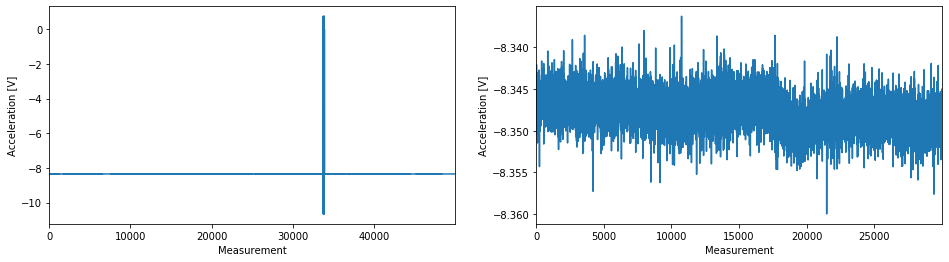

In [22]:
fig, ax =plt.subplots(ncols=2, figsize=(16,4))
memsdata.plot(ax=ax[0])
memsdata[0:30000].plot(ax=ax[1])
for i in range(2):
    ax[i].set_xlabel("Measurement")
    ax[i].set_ylabel("Acceleration [V]")

We see that we have some missing data/ error between 30000 and 40000. I will get rid of them later.  
We need:
- get rid of the corrupt data 
    - does it affect phase extraction?
- Bias correction on <code>memsdata</code> and <code>memsdata0</code> separately
    - relationship between them?

### Fringe data import

In [23]:
ACCdata = pd.read_table("20200818/1100_.txt",names=["Phase","P2"])

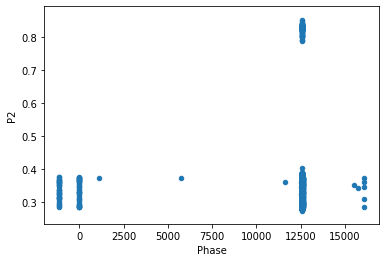

In [24]:
ACCdata.plot.scatter(x="Phase",y="P2")

Oh dear.. something happend here. I suspect that the data point above $P_2$>0.5 are due to the spike in the MEMS data. To understand:
- why are there multiple clustered data? 
    - shouldnt they be all together?!

### TPin data import

In [25]:
TPindata = pd.read_csv("20200818/20_08_18_10_59_55_Temp.csv", names=["TPin"])

In [28]:
len(TPindata)

50339

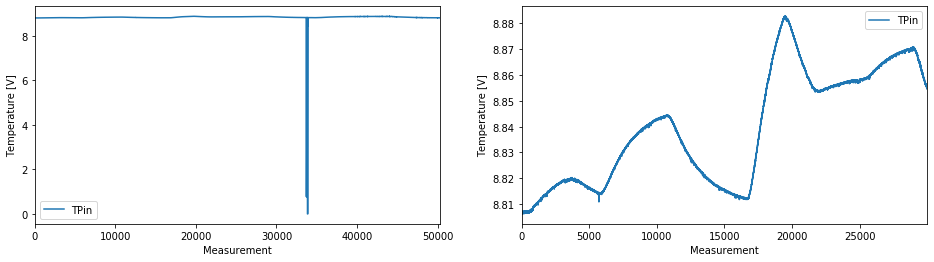

In [30]:
fig, ax =plt.subplots(ncols=2, figsize=(16,4))
TPindata.plot(ax=ax[0])
TPindata[0:30000].plot(ax=ax[1])
for i in range(2):
    ax[i].set_xlabel("Measurement")
    ax[i].set_ylabel("Temperature [V]")

We can see here, that the spike speared in all data set. 
The temperature pin looks very similiar to the thermal couple data. We need to compare these two.

## Data cleansing: Combining data - Unified dataframe

The acquisition of TPin and Acceleration data are not stopped at the same time. Let us combine them into the same dataframe. From there, we can also get rid of all data which are corrupted. 

In [34]:
print("length of the TPin data is: "+str(len(TPindata)))
print("length of the acceleration data is: "+str(len(ACCdata)))
print("length of the raw MEMS data is: "+str(len(memsdata)))

length of the TPin data is: 50339
length of the acceleration data is: 50001
length of the raw MEMS data is: 49934


TPin data is trigger-started at the same time as the acceleration data. However, it is stopped few min later.  
The raw MEMS data should be of the same length as the acceleration data. The discrepancy shows some data are missed out. Ideally, I wouldnt use these to do position integration. But let us see if it actually makes a difference.  
For the start, I will just use the Phase from the acceleration file. 

In [36]:
data_len = len(memsdata)

In [37]:
df = ACCdata[:data_len].copy()

In [38]:
df["TPin"]=TPindata[:data_len]
df["MEMS"]=memsdata

let us start some conditioins for cleansing:

In [54]:
df=df[(df["P2"]<0.5)]
df=df[(8.8<df["TPin"])]
df=df[(df["Phase"]<15000)&(12000<df["Phase"])]

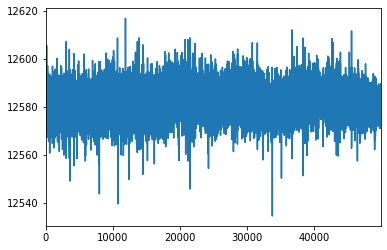

In [57]:
df["Phase"].plot()

In [62]:
print("We started with "+str(data_len)+"files")
print("and got rid of {} files".format(data_len-df.shape[0]))

We started with 49934files
and got rid of 205 files


This is the key step:  <b>What I found in the past</b>  
Centralising data helps to significantly reduce the contribution of the scaling factor. The effect of the scaling factor is more prominent for large acceleration acceleration. (i.e. If we were at 1000 fringe, the scaling factor changes the offset phase by a factor of 1000.)  
By centralising the data, we decouple to a great deal the scaling factor from the offset phase. 

In [74]:
df["Phase_New"]=df["Phase"]-df["Phase"].mean()
# I added:
# - a minus sign for the mems for the phase and MEMS to to always positive correlated
df["MEMS_New"]=-(df["MEMS"]-df["MEMS"].mean())

# Validating MEMS signal change due to Temperature

Since we have changed the temperature by 20$^{\circ}$, I am expecting the temperature data to be correlated with the MEMS signa change.  
I adjust the acceleration reading and for better visuals, I will use rolling average over 2min and simple averaging over 2 min data.

In [75]:
df["TPin_New"]=(df["TPin"]-df["TPin"].mean())

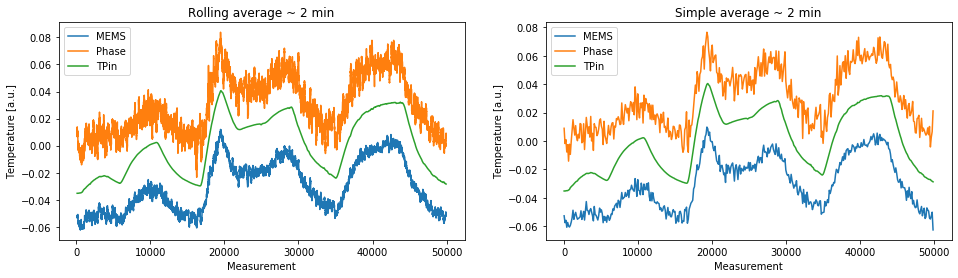

In [116]:
fig, ax =plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(df["MEMS_New"].rolling(120).mean()*20-0.03)
ax[0].plot(df["Phase_New"].rolling(120).mean()/70+0.03)
ax[0].plot(df["TPin_New"].rolling(120).mean())
ax[0].legend(["MEMS","Phase","TPin"])
ax[0].set_title("Rolling average ~ 2 min")

df_avg = df.groupby(df.index//120).mean()
df_avg.index=df_avg.index.values*120

ax[1].plot(df_avg["MEMS_New"]*20-0.03)
ax[1].plot(df_avg["Phase_New"]/70+0.03)
ax[1].plot(df_avg["TPin_New"])
ax[1].legend(["MEMS","Phase","TPin"])
ax[1].set_title("Simple average ~ 2 min")

for i in range(2):
    ax[i].set_xlabel("Measurement")
    ax[i].set_ylabel("Temperature [a.u.]")

it is clear that the MEMS signal is correlated with the Temperature Pin. The poin tis to beat the correction using the temperature pin.  
Let us first calibrate the TPin.

In [118]:
def linModel(x, k,d):
    return d+k*x
# col 0: Temperature
# col 1: Phase
poptTPin= lambda data: curve_fit(linModel, data.iloc[:,0], data.iloc[:,1],p0=[0.5,0.1])[0]

In [142]:
Tscaling = poptTPin(df[["TPin_New","Phase_New"]])
Tscaling_avg = poptTPin(df_avg[["TPin_New","Phase_New"]])
print("The slope of no-averaged data is {:.3f}".format(Tscaling[0]))
print("The slope of 2-min averaged data is {:.3f}".format(Tscaling_avg[0]))

The slope of no-averaged data is 65.561
The slope of 2-min averaged data is 65.456


In [143]:
import seaborn as sns

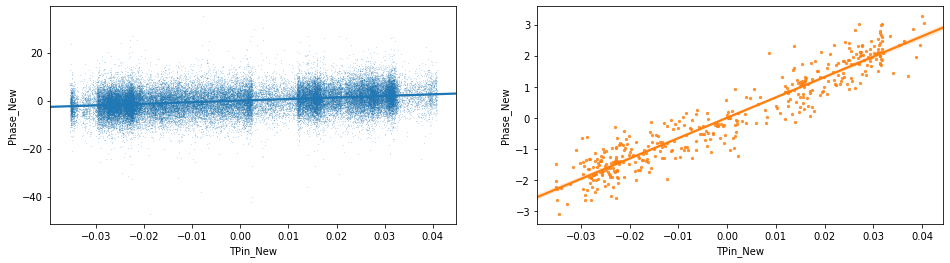

In [157]:
fig, ax = plt.subplots(ncols=2,figsize=(16,4))
sns.regplot(df["TPin_New"], 
            df["Phase_New"],
            scatter_kws={"s": 0.01}, ax=ax[0])
sns.regplot(df_avg["TPin_New"], 
            df_avg["Phase_New"],
            scatter_kws={"s": 5}, ax=ax[1])


Before proceeding to the phase correction, let us just double check the data.

(-20, 20)

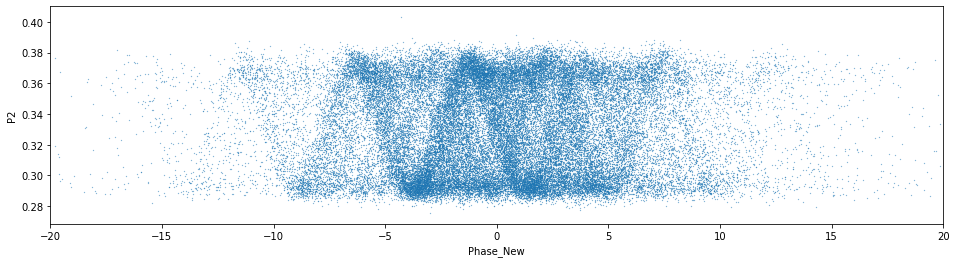

In [174]:
fig, ax= plt.subplots(figsize=(16,4))
df.plot.scatter(x="Phase_New",y="P2",ax=ax, s=0.05)
ax.set_xlim([-20,20])

Very clear to see that the fringe has moved around due to the Temperature.

As the last thing, let us how the MEMS data correlated with Phase data. My main worry is that the missed data in MEMS might have contribution on the stability:  
- Let us check this

(-0.002, 0.002)

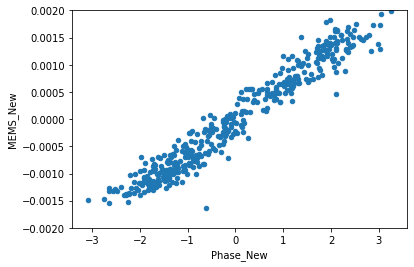

In [179]:
df_avg.plot.scatter(x="Phase_New",y="MEMS_New")
plt.ylim([-0.002,0.002])

## Using temperature pin to correct bias drift

Now, I will use the temperature reading to correct the drift of the signal. 
These are the senarios, that we will look at:
- 120 bins rolling averaged
- 120 bins simple average

In [198]:
def getCorrTempdata(data,nrwindow, optNr):
    # if optNr = 1 --> ROlling, else --> simple average
    if optNr ==1:
        tempMEMSdata = data.rolling(nrwindow).mean().dropna()
    else:
        tempMEMSdata = data.groupby(data.index//nrwindow).mean()
    tempMEMSdata["Phase_Corr"] = tempMEMSdata["Phase_New"]-(poptTPin(tempMEMSdata[["TPin_New","Phase_New"]])[0]*tempMEMSdata["TPin_New"])
    return tempMEMSdata

In [200]:
tempMEMSdataR1 = getCorrTempdata(df,1,1)
tempMEMSdataR120 = getCorrTempdata(df,120,1)

tempMEMSdataS1 = getCorrTempdata(df,1,0)
tempMEMSdataS120 = getCorrTempdata(df,120,0)

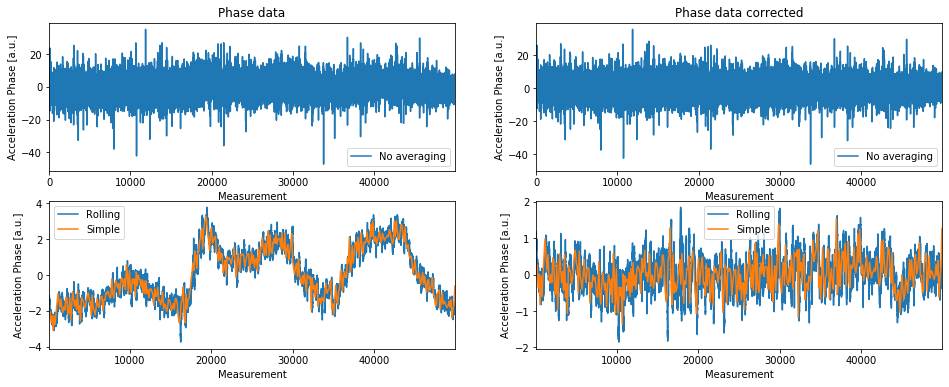

In [232]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(16,6))
tempMEMSdataR1.plot(y=["Phase_New"],ax=ax[0,0])
ax[0,0].legend(["No averaging"])
ax[0,0].set_title("Phase data")
tempMEMSdataR120.plot(y=["Phase_New"],ax=ax[1,0])
ax[1,0].plot(tempMEMSdataS120.index.values*120,tempMEMSdataS120["Phase_New"])
ax[1,0].legend(["Rolling","Simple"])

tempMEMSdataR1.plot(y=["Phase_Corr"],ax=ax[0,1])
ax[0,1].legend(["No averaging"])
ax[0,1].set_title("Phase data corrected")
tempMEMSdataR120.plot(y=["Phase_Corr"],ax=ax[1,1])
ax[1,1].plot(tempMEMSdataS120.index.values*120,tempMEMSdataS120["Phase_Corr"])
ax[1,1].legend(["Rolling","Simple"])

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("Measurement")
        ax[i,j].set_ylabel("Acceleration Phase [a.u.]")

Let us look at the stability in terms of Allan deviation.

In [233]:
def plotallan(plt, y, rate, taus):
    (t2, ad, ade, adn) = at.adev(y, rate=rate, data_type="freq", taus=taus)
    plt.loglog(t2, ad)

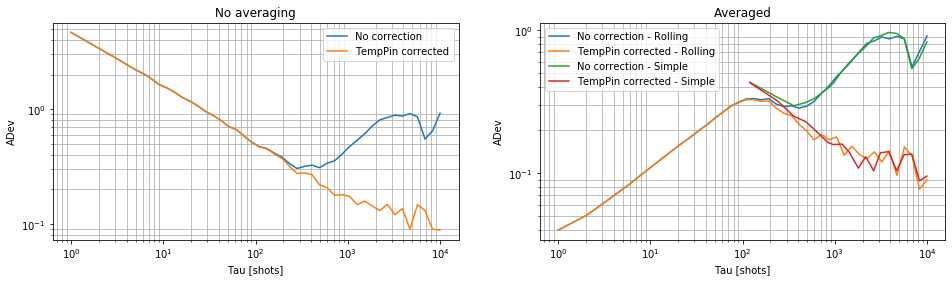

In [253]:
t = np.logspace(0, 4, 50)
fig, ax = plt.subplots(ncols= 2, figsize=(16,4))
for i,data in enumerate([tempMEMSdataR1,tempMEMSdataR120,tempMEMSdataS120]):
    rate=1
    if i==2:
        i=1
        rate = 1/120
    plotallan(ax[i], (data["Phase_New"]).tolist(), rate, t)
    plotallan(ax[i], (data["Phase_Corr"]).tolist(), rate, t)
for i in range(2):   
    ax[i].set_xlabel("Tau [shots]")
    ax[i].set_ylabel("ADev")
    ax[i].grid(which="minor")
ax[0].set_title("No averaging")
ax[0].legend(["No correction","TempPin corrected"])
ax[1].set_title("Averaged")
ax[1].legend(["No correction - Rolling","TempPin corrected - Rolling",
             "No correction - Simple","TempPin corrected - Simple"])

Left: No average, right: 120 bins rolling and simple average.  
It is clear to see that the rolling average cancels the high freqeuncy noise. However, from >100s, the rolling average doesnt make any difference, as this is the real signal, which is drifting. 

### Different (rolling)-averaging durations

Text(0.5, 1.0, 'Rolling average')

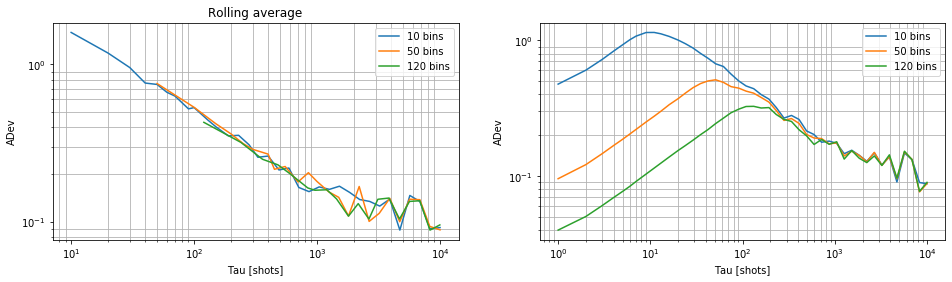

In [270]:
t = np.logspace(0, 4, 50)
fig, ax = plt.subplots(ncols= 2, figsize=(16,4))
for i in range(2):
    for ind, data in enumerate([getCorrTempdata(df,10,i),getCorrTempdata(df,50,i),getCorrTempdata(df,120,i)]):
        if i==0: # for simple average, I need to adjust the rate.
            if ind == 0:
                rate = 1/10
            elif ind ==1:
                rate = 1/50
            else:
                rate = 1/120
        else: # rolling average has a rate of 1, always
            rate = 1
        plotallan(ax[i], (data["Phase_Corr"]).tolist(), rate, t) 
        ax[i].set_xlabel("Tau [shots]")
        ax[i].set_ylabel("ADev")
        ax[i].grid(which="minor")
        ax[i].legend(["10 bins","50 bins", "120 bins"])
ax[0].set_title("Rolling average") 


Different averaging schemes doesnt have effect on the drift, which seems to reach the bottom between 300-500 shots. The corrected seem to go done contineously.

This effectively shows that rolling average is as good as simple average.

## Correcting raw MEMS data

Let us repeat what we have done previously.

In [274]:
def getCorrTempMEMSdata(data,nrwindow, optNr):
    # if optNr = 1 --> ROlling, else --> simple average
    if optNr ==1:
        tempMEMSdata = data.rolling(nrwindow).mean().dropna()
    else:
        tempMEMSdata = data.groupby(data.index//nrwindow).mean()
    tempMEMSdata["MEMS_Corr"] = tempMEMSdata["MEMS_New"]-(poptTPin(tempMEMSdata[["TPin_New","MEMS_New"]])[0]*tempMEMSdata["TPin_New"])
    return tempMEMSdata

In [275]:
rawMEMSdataR1_corr = getCorrTempMEMSdata(df,1,1)
rawMEMSdataR120_corr = getCorrTempMEMSdata(df,120,1)
rawMEMSdataS1_corr = getCorrTempMEMSdata(df,1,0)
rawMEMSdataS120_corr = getCorrTempMEMSdata(df,120,0)

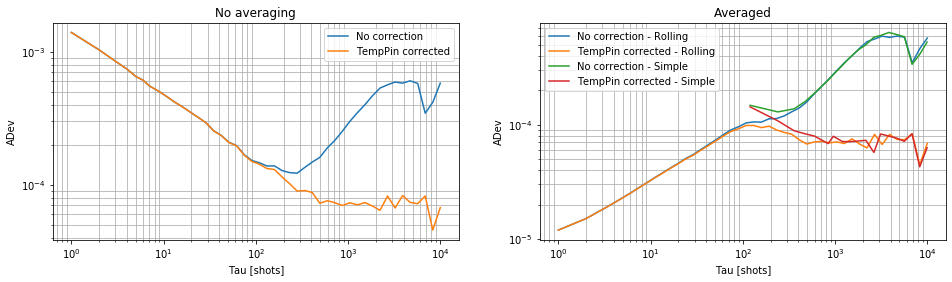

In [276]:
t = np.logspace(0, 4, 50)
fig, ax = plt.subplots(ncols= 2, figsize=(16,4))
for i,data in enumerate([rawMEMSdataR1_corr,rawMEMSdataR120_corr,rawMEMSdataS120_corr]):
    rate=1
    if i==2:
        i=1
        rate = 1/120
    plotallan(ax[i], (data["MEMS_New"]).tolist(), rate, t)
    plotallan(ax[i], (data["MEMS_Corr"]).tolist(), rate, t)
for i in range(2):   
    ax[i].set_xlabel("Tau [shots]")
    ax[i].set_ylabel("ADev")
    ax[i].grid(which="minor")
ax[0].set_title("No averaging")
ax[0].legend(["No correction","TempPin corrected"])
ax[1].set_title("Averaged")
ax[1].legend(["No correction - Rolling","TempPin corrected - Rolling",
             "No correction - Simple","TempPin corrected - Simple"])

Text(0.5, 1.0, 'Rolling average')

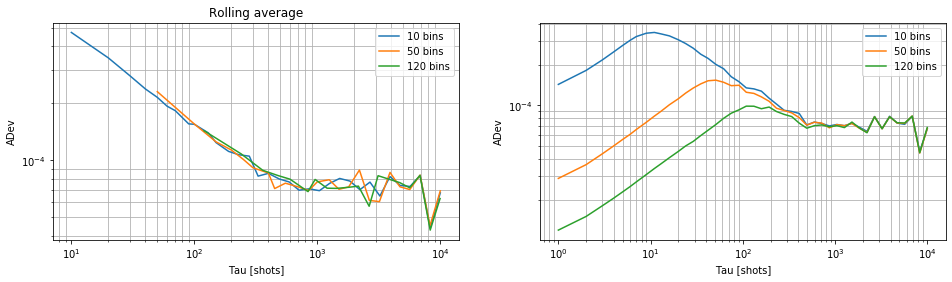

In [277]:
t = np.logspace(0, 4, 50)
fig, ax = plt.subplots(ncols= 2, figsize=(16,4))
for i in range(2):
    for ind, data in enumerate([getCorrTempMEMSdata(df,10,i),
                                getCorrTempMEMSdata(df,50,i),
                                getCorrTempMEMSdata(df,120,i)]):
        if i==0: # for simple average, I need to adjust the rate.
            if ind == 0:
                rate = 1/10
            elif ind ==1:
                rate = 1/50
            else:
                rate = 1/120
        else: # rolling average has a rate of 1, always
            rate = 1
        plotallan(ax[i], (data["MEMS_Corr"]).tolist(), rate, t) 
        ax[i].set_xlabel("Tau [shots]")
        ax[i].set_ylabel("ADev")
        ax[i].grid(which="minor")
        ax[i].legend(["10 bins","50 bins", "120 bins"])
ax[0].set_title("Rolling average") 


This is interesting. Using the raw MEMS data, the Allan dev doesnt go donw as much as Acc phase. This could indicate the noise power at higher frequency, which was filtered out when calculating the Acceleration phase in sensitivity function.

Let us return to this point later to estimate the positioning uncertainty.

# Looking at fringe pattern

Let us now include the atomic signal and extract the bias interferometer phase.

In [288]:
def model(x, p20, C, eta, phi0):
    return p20+abs(C)/2*np.cos(eta*x+phi0)

In [289]:
data= df
nset= 120

p20list=[]
clist=[]
etalist=[]
phi0list=[]
# initial guess
p00=[0.28,0.08,1.23,2]

xdataRolllist=[]
xdataRollCorrEtalist=[]
xdataRollCorrEtaPhi0list=[]

# here i perform a moving selection
for ind in range(len(data)-nset):
    xdata = data["Phase_New"][ind:ind+nset]
    ydata = data["P2"][ind:ind+nset]
    popt, pcov = curve_fit(model, 
                           xdata, 
                           ydata,
                           # updating the new guess
                           p0=p00,
                           # here i restrict the fit parameter by the prev value
                           bounds=((p00[0]-0.03, p00[1]-0.01, p00[2]-0.2, p00[3]-1),
                                   (p00[0]+0.03,p00[1]+0.01,p00[2]+0.2,p00[3]+1))
                          )
    p00=popt
    #yhat = model(xdata)
    #avgRes = np.sqrt(((ydata-yhat)**2).mean())
    
    xdataRollMean = xdata.mean()
    # mems data rolling average
    xdataRolllist.append(xdataRollMean)
    #scaling factor corred - acceleration phase
    xdataRollCorrEtalist.append(p00[2]*xdataRollMean)
    # scaling and bias corrected - acceleartion phase
    xdataRollCorrEtaPhi0list.append(p00[2]*xdataRollMean+p00[3])
    
    for i in zip([p20list, clist, etalist, phi0list],
                 popt):
        i[0].append(i[1])
    

KeyboardInterrupt: 

In [386]:
def extractFringeR(data, nrbins):
    p20list=[]
    clist=[]
    etalist=[]
    phi0list=[]
    # initial guess
    p00=[0.28,0.08,1.23,2]

    xdataRolllist=[]
    xdataRollCorrEtalist=[]
    xdataRollCorrEtaPhi0list=[]

    # here i perform a moving selection
    for ind in range(len(data)-nrbins):
        xdata = data["Phase_New"][ind:ind+nrbins]
        ydata = data["P2"][ind:ind+nrbins]
        popt, pcov = curve_fit(model, 
                               xdata, 
                               ydata,
                           # updating the new guess
                               p0=p00,
                           # here i restrict the fit parameter by the prev value
                               bounds=((p00[0]-0.03, p00[1]-0.01, p00[2]-0.2, p00[3]-1),
                                       (p00[0]+0.03,p00[1]+0.01,p00[2]+0.2,p00[3]+1))
                              )
        p00=popt
        xdataRollMean = xdata.mean()
        # mems data rolling average
        xdataRolllist.append(xdataRollMean)
    #scaling factor corred - acceleration phase
        xdataRollCorrEtalist.append(p00[2]*xdataRollMean)
    # scaling and bias corrected - acceleartion phase
        xdataRollCorrEtaPhi0list.append(p00[2]*xdataRollMean+p00[3])
    
        for i in zip([p20list, clist, etalist, phi0list],
                     popt):
            i[0].append(i[1])
    return p20list, clist, etalist, phi0list, xdataRolllist, xdataRollCorrEtalist, xdataRollCorrEtaPhi0list

These take very long to calculate

In [469]:
p20listR120, clistR120, etalistR120, phi0listR120, xdataRollR120, xdataRollCorrEtaR120, xdataRollCorrEtaPhi0R120 = extractFringeR(df, 120)

In [468]:
p20listR60, clistR60, etalistR60, phi0listR60, xdataRollR60, xdataRollCorrEtaR60, xdataRollCorrEtaPhi0R60 = extractFringeR(df, 60)

#### 60 bins rolling average

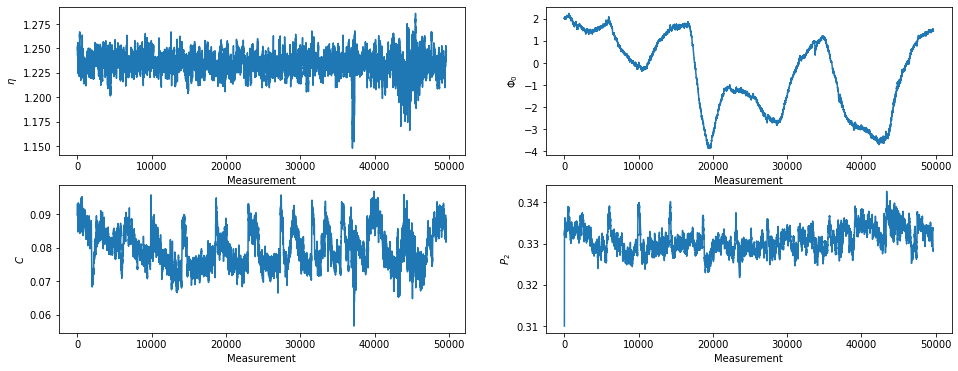

In [389]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(16,6))
ax[0,0].plot(np.abs(etalistR60))
ax[0,0].set_ylabel("$\eta$")
ax[0,1].plot(phi0listR60)
ax[0,1].set_ylabel("$\Phi_0$")
ax[1,0].plot(np.abs(clistR60))
ax[1,0].set_ylabel("$C$")
ax[1,1].plot(p20listR60)
ax[1,1].set_ylabel("$P_2$")

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("Measurement")

#### 120 bins rolling average

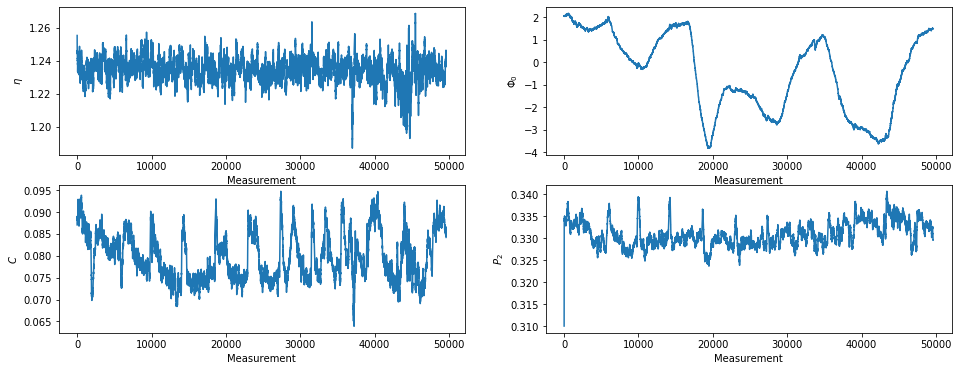

In [390]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(16,6))
ax[0,0].plot(np.abs(etalistR120))
ax[0,0].set_ylabel("$\eta$")
ax[0,1].plot(phi0listR120)
ax[0,1].set_ylabel("$\Phi_0$")
ax[1,0].plot(np.abs(clistR120))
ax[1,0].set_ylabel("$C$")
ax[1,1].plot(p20listR120)
ax[1,1].set_ylabel("$P_2$")

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("Measurement")

#### Simple average

In [470]:
def extractFringeS(data, nrbins):
    p20list=[]
    clist=[]
    etalist=[]
    phi0list=[]
    # initial guess
    p00=[0.28,0.08,1.23,2]

    xdataRolllist=[]
    xdataRollCorrEtalist=[]
    xdataRollCorrEtaPhi0list=[]

    # here i perform a moving selection
    for ind in range(int(len(data)/nrbins)):
        xdata = data["Phase_New"][ind*nrbins:(ind+1)*nrbins]
        ydata = data["P2"][ind*nrbins:(ind+1)*nrbins]
        popt, pcov = curve_fit(model, 
                               xdata, 
                               ydata,
                           # updating the new guess
                               p0=p00,
                           # here i restrict the fit parameter by the prev value
                               bounds=((p00[0]-0.03, p00[1]-0.01, p00[2]-0.2, p00[3]-1),
                                       (p00[0]+0.03,p00[1]+0.01,p00[2]+0.2,p00[3]+1))
                              )
        p00=popt
        xdataRollMean = xdata.mean()
        # mems data rolling average
        xdataRolllist.append(xdataRollMean)
    #scaling factor corred - acceleration phase
        xdataRollCorrEtalist.append(p00[2]*xdataRollMean)
    # scaling and bias corrected - acceleartion phase
        xdataRollCorrEtaPhi0list.append(p00[2]*xdataRollMean+p00[3])
    
        for i in zip([p20list, clist, etalist, phi0list],
                     popt):
            i[0].append(i[1])
    return p20list, clist, etalist, phi0list, xdataRolllist, xdataRollCorrEtalist, xdataRollCorrEtaPhi0list

In [471]:
p20listS60, clistS60, etalistS60, phi0listS60, xdataRollS60, xdataRollCorrEtaS60, xdataRollCorrEtaPhi0S60 = extractFringeS(df, 60)

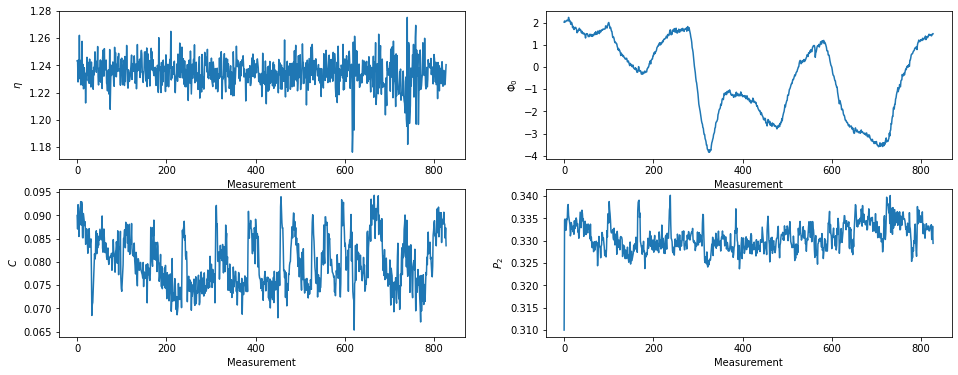

In [472]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(16,6))
ax[0,0].plot(np.abs(etalistS60))
ax[0,0].set_ylabel("$\eta$")
ax[0,1].plot(phi0listS60)
ax[0,1].set_ylabel("$\Phi_0$")
ax[1,0].plot(np.abs(clistS60))
ax[1,0].set_ylabel("$C$")
ax[1,1].plot(p20listS60)
ax[1,1].set_ylabel("$P_2$")

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("Measurement")

### Look more into detail

$\Phi_0$ looks very correlated with TPin.

In [473]:
phi0listR60=np.array(phi0listR60, dtype=float)
phi0listR120=np.array(phi0listR120, dtype=float)
phi0listS60=np.array(phi0listS60, dtype=float)

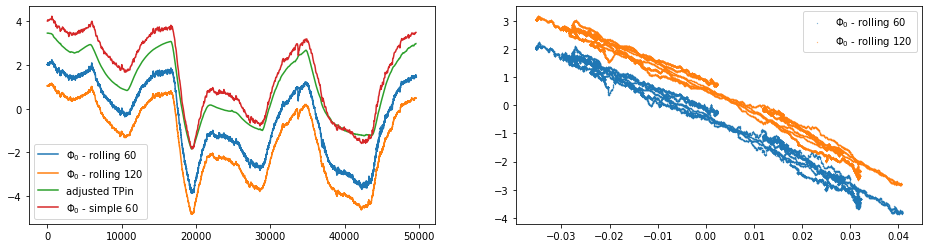

In [474]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(np.arange(len(phi0listR60)),phi0listR60)
ax[0].plot(np.arange(len(phi0listR120)),phi0listR120-1)
ax[0].plot(np.arange(len(phi0listR120)),
              -df.rolling(120).mean().dropna()[:-1]["TPin_New"]*70+1)
ax[0].plot(np.arange(len(phi0listS60))*60,phi0listS60+2)
ax[0].legend(["$\Phi_0$ - rolling 60","$\Phi_0$ - rolling 120","adjusted TPin","$\Phi_0$ - simple 60"])

ax[1].scatter(df.rolling(60).mean().dropna()[:-1]["TPin_New"], phi0listR60, s=0.05)
ax[1].scatter(df.rolling(120).mean().dropna()[:-1]["TPin_New"], phi0listR120+1, s=0.05)
ax[1].legend(["$\Phi_0$ - rolling 60","$\Phi_0$ - rolling 120"])

The offset phase drifted by 6 rad, which corresponds to 380ug in 2T=20 ms interferomter. Given the temperature is drifted by 20C with a specified drift of <30ug/C. The measured drift using AI completely makes sense!

It is pretty good correlated. But the correlation plot shows some deviation. 

In [475]:
corr_R60 = curve_fit(linModel, 
                     df.rolling(60).mean().dropna()[:-1]["TPin_New"], 
                     phi0listR60,
                     p0=[0.5,0.1])[0]
corr_R120 = curve_fit(linModel, 
                     df.rolling(120).mean().dropna()[:-1]["TPin_New"], 
                     phi0listR120,
                     p0=[0.5,0.1])[0]

In [394]:
phi0R60_hat = corr_R60[1]+corr_R60[0]*df.rolling(60).mean().dropna()[:-1]["TPin_New"]-phi0listR60
phi0R120_hat = corr_R120[1]+corr_R120[0]*df.rolling(120).mean().dropna()[:-1]["TPin_New"]-phi0listR120

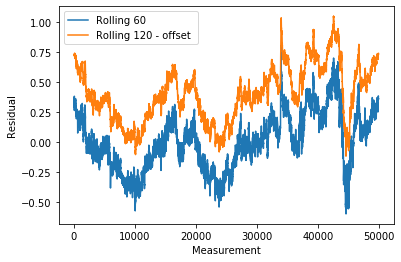

In [395]:
plt.plot(phi0R60_hat)
plt.plot(phi0R120_hat+0.4)
plt.xlabel("Measurement")
plt.ylabel("Residual")
plt.legend(["Rolling 60","Rolling 120 - offset " ])

This is the time dependence of the residual signal.

I am not going to look deeper into the other parameters, as those would take more time and effort and potentially points to other issues. This would potentially results in futher data collection, which exceeds the scope of this notebook.

<b>Let us now move on to correction!</b>

In [476]:
keff=4*np.pi/0.00000078
T=0.01
g=9.81

In [477]:
xdataRollR120=np.array(xdataRollR120)/(keff*T**2*g*0.001)
xdataRollCorrEtaR120=np.array(xdataRollCorrEtaR120)/(keff*T**2*g*0.001)
xdataRollCorrEtaPhi0R120=np.array(xdataRollCorrEtaPhi0R120)/(keff*T**2*g*0.001)

xdataRollR60=np.array(xdataRollR60)/(keff*T**2*g*0.001)
xdataRollCorrEtaR60=np.array(xdataRollCorrEtaR60)/(keff*T**2*g*0.001)
xdataRollCorrEtaPhi0R60=np.array(xdataRollCorrEtaPhi0R60)/(keff*T**2*g*0.001)

xdataRollS60=np.array(xdataRollS60)/(keff*T**2*g*0.001)
xdataRollCorrEtaS60=np.array(xdataRollCorrEtaS60)/(keff*T**2*g*0.001)
xdataRollCorrEtaPhi0S60=np.array(xdataRollCorrEtaPhi0S60)/(keff*T**2*g*0.001)

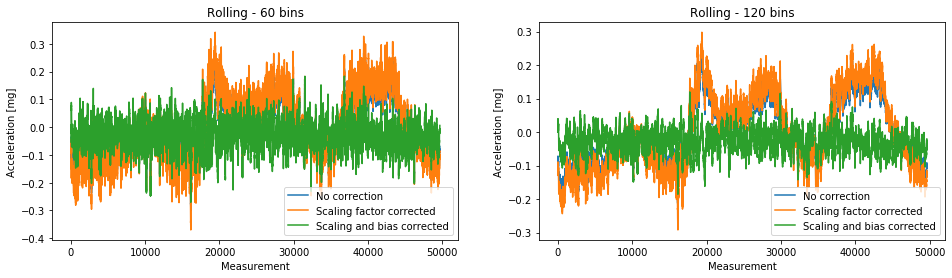

In [478]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
for data in [xdataRollR60,xdataRollCorrEtaR60,xdataRollCorrEtaPhi0R60]:
    ax[0].plot(data)
    ax[0].set_title("Rolling - 60 bins")
for data in [xdataRollR120,xdataRollCorrEtaR120,xdataRollCorrEtaPhi0R120]:
    ax[1].plot(data)
    ax[1].set_title("Rolling - 120 bins")
    
for i in range(2):    
    ax[i].set_xlabel("Measurement")
    ax[i].set_ylabel("Acceleration [mg]")
    ax[i].legend(["No correction","Scaling factor corrected", "Scaling and bias corrected"])

In [479]:
def plotallan(plt, y, rate, taus):
    (t2, ad, ade, adn) = at.adev(y, rate=rate, data_type="freq", taus=taus)
    plt.loglog(t2, ad)

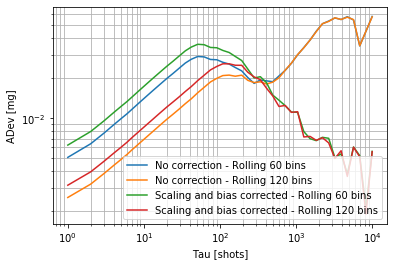

In [480]:
t = np.logspace(0, 4, 50)
plotallan(plt, xdataRollR60, 1, t)
plotallan(plt, xdataRollR120, 1, t)
plotallan(plt, xdataRollCorrEtaPhi0R60, 1, t)
plotallan(plt, xdataRollCorrEtaPhi0R120, 1, t)
plt.xlabel("Tau [shots]")
plt.ylabel("ADev [mg]")
plt.grid(which="minor")
plt.legend(["No correction - Rolling 60 bins",
            "No correction - Rolling 120 bins",
            "Scaling and bias corrected - Rolling 60 bins",
           "Scaling and bias corrected - Rolling 120 bins"])


Different rolling bin size literally doesn't make any difference in the long term stability.. Let us now fix us at 60 bins.

Text(0.5, 1.0, 'Phase correction')

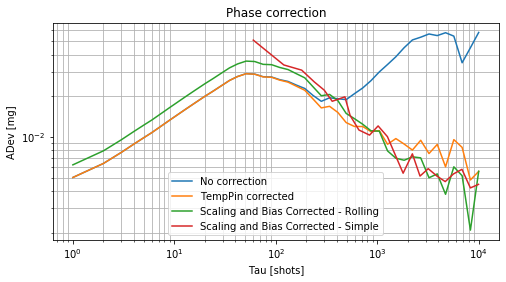

In [484]:
t = np.logspace(0, 4, 50)
fig, ax = plt.subplots(ncols= 1, figsize=(8,4))

plotallan(ax, ((getCorrTempdata(df,60, 1)["Phase_New"])/(keff*T**2*g*0.001)).tolist(), 1, t)
plotallan(ax, ((getCorrTempdata(df,60, 1)["Phase_Corr"])/(keff*T**2*g*0.001)).tolist(), 1, t)
plotallan(ax, xdataRollCorrEtaPhi0R60, 1, t)
plotallan(ax, xdataRollCorrEtaPhi0S60, 1/60, t)
ax.set_xlabel("Tau [shots]")
ax.set_ylabel("ADev [mg]")
ax.grid(which="minor")
ax.legend(["No correction","TempPin corrected","Scaling and Bias Corrected - Rolling", "Scaling and Bias Corrected - Simple"])
ax.set_title("Phase correction")

## Position integration

In [485]:
xdataRollCorrEtaPhi0R60

array([-0.05359289, -0.04610572, -0.03472567, ...,  0.00491591,
        0.00407589,  0.00611212])

In [596]:
def getPos(acclist,dt):
    return [10**(-3)*9.81*acclist[0:i].sum()*dt**2/2 + 10**(-3)*9.81*acclist[0:i].cumsum().sum()*dt**2 for i in range(20,20*int(len(acclist)/20),20)]
def getPosSgl(acclist,dt):
    return 10**(-3)*9.81*acclist.sum()*dt**2/2 + 10**(-3)*9.81*acclist.cumsum().sum()*dt**2

def calibAcc(data, nrcal):
    return data[calnr:]-(data[0:calnr].mean())
    

In [556]:
calnr=120
rollingPhi0Corr =xdataRollCorrEtaPhi0R60[calnr:]-(xdataRollCorrEtaPhi0R60[0:calnr].mean())
rollingEtaCorr =xdataRollCorrEtaR60[calnr:]-(xdataRollCorrEtaR60[0:calnr].mean())
rollingData =xdataRollR60[calnr:]-(xdataRollR60[0:calnr].mean())
TPinCorr =np.array(((getCorrTempdata(df,60, 1)["Phase_Corr"])/(keff*T**2*g*0.001)).tolist())
TPinCorr= TPinCorr[calnr:]-(TPinCorr[0:calnr].mean())

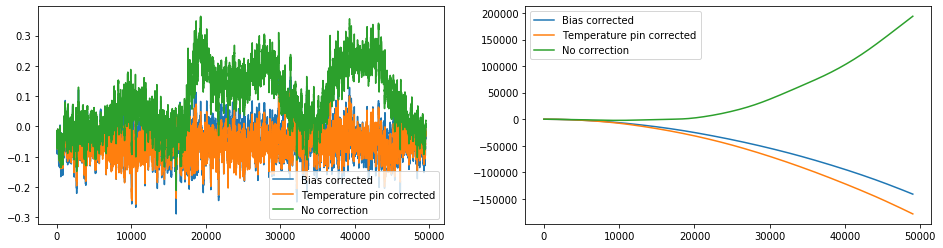

In [557]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(rollingPhi0Corr)
ax[0].plot(TPinCorr)
ax[0].plot(rollingData)
ax[0].legend(["Bias corrected","Temperature pin corrected","No correction"])

ax[1].plot(200*np.arange(len(getPos(rollingPhi0Corr,0.5))),getPos(rollingPhi0Corr,0.5))
ax[1].plot(200*np.arange(len(getPos(TPinCorr,0.5))),getPos(TPinCorr,0.5))
ax[1].plot(200*np.arange(len(getPos(rollingData,0.5))),getPos(rollingData,0.5))
ax[1].legend(["Bias corrected","Temperature pin corrected","No correction"])

We know that the gravimeter hasnt change and hence we set the reference to be zero.  
TIt seems that the final discrepancy is heavly depending on the duringtion we use for calibration.

In [699]:
accDF = pd.DataFrame()

In [700]:
accDF["TPinCorr"]=TPinCorr
accDF["BiasCorr"]=xdataRollCorrEtaPhi0R60[0:len(TPinCorr)]
accDF["NoCorr"]=xdataRollR60[0:len(TPinCorr)]


In [701]:
nrdata = 8000
nocorrlist =[]
tpincorrlist =[]
phi0corrlist =[]
for i in range(int(len(accDF)/nrdata)):
    nocorrlist.append(getPosSgl(calibAcc(accDF["NoCorr"][i*nrdata:(i+1)*nrdata], 1000),0.5))
    tpincorrlist.append(getPosSgl(calibAcc(accDF["TPinCorr"][i*nrdata:(i+1)*nrdata], 1000),0.5))
    phi0corrlist.append(getPosSgl(calibAcc(accDF["BiasCorr"][i*nrdata:(i+1)*nrdata], 1000),0.5))


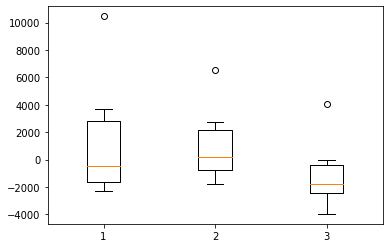

In [702]:
plt.boxplot([nocorrlist,tpincorrlist,phi0corrlist])
plt.show()

In [703]:

def getStats(data,nrdata, nrcal):
    nocorrlist =[]
    tpincorrlist =[]
    phi0corrlist =[]
    for i in range(int(len(data)/nrdata)):
        nocorrlist.append(getPosSgl(calibAcc(data["NoCorr"][i*nrdata:(i+1)*nrdata], nrcal),0.5))
        tpincorrlist.append(getPosSgl(calibAcc(data["TPinCorr"][i*nrdata:(i+1)*nrdata], nrcal),0.5))
        phi0corrlist.append(getPosSgl(calibAcc(data["BiasCorr"][i*nrdata:(i+1)*nrdata], nrcal),0.5))
    return [np.mean(nocorrlist), np.mean(tpincorrlist), np.mean(phi0corrlist),np.std(nocorrlist), np.std(tpincorrlist), np.std(phi0corrlist)]

In [706]:
accDF1=accDF[5000:15000]
accDF2=accDF[10000:20000]
accDF3=accDF[15000:25000]

In [709]:
meanlist=[]
stdlist=[]
for i in np.arange(100,15000,100):
    meanlist.append(getStats(accDF1,i, 50)[0:3])
    stdlist.append(getStats(accDF1,i, 50)[3:6])

meanlist=pd.DataFrame(meanlist, columns = ["NoCorr","TPinCorr","BiasCorr"])
meanlist.index=np.array(np.arange(100,15000,100))
    
stdlist=pd.DataFrame(stdlist, columns = ["NoCorr","TPinCorr","BiasCorr"])
stdlist.index=np.array(np.arange(100,15000,100))

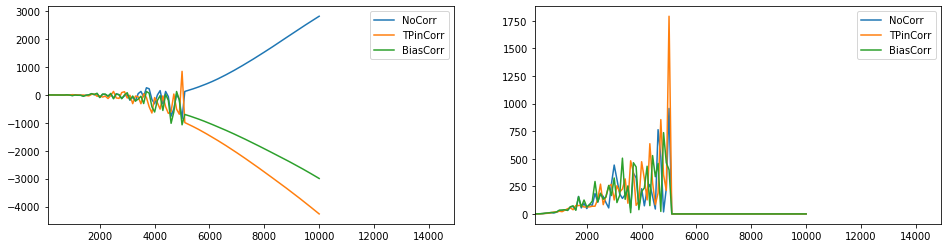

In [710]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
meanlist.plot(ax=ax[0])
stdlist.plot(ax=ax[1])

In [717]:
meanlist=[]
stdlist=[]
for i in np.arange(100,10000,100):
    meanlist.append(getStats(accDF2,i, 50)[0:3])
    stdlist.append(getStats(accDF2,i, 50)[3:6])

meanlist=pd.DataFrame(meanlist, columns = ["NoCorr","TPinCorr","BiasCorr"])
meanlist.index=np.array(np.arange(100,10000,100))
    
stdlist=pd.DataFrame(stdlist, columns = ["NoCorr","TPinCorr","BiasCorr"])
stdlist.index=np.array(np.arange(100,10000,100))

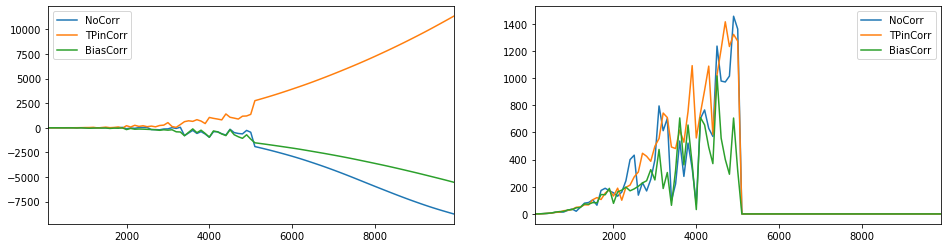

In [718]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
meanlist.plot(ax=ax[0])
stdlist.plot(ax=ax[1])